In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import math
from scipy.constants import m_u,c,e
from bisect import bisect
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import simpson


In [2]:
def load(path, date, sh):
    ch = [ 'C4', 'C6']
    data = {}
    binit = True
    for c in ch:
        f = path + c + '--' + date + sh +'--00000.txt'
        t,v = np.genfromtxt(f, unpack=True, skip_header=5, delimiter=',')
        if(binit):
            data['t'] = t
            binit = False
        data[c] = v
    return data

def moving_average(a, n=300):
    s = np.convolve(a, np.ones(n)/n, mode='same')
    return s

def hl_envelopes_idx(s, d, split=True):
    lmin = find_peaks(-s, distance=d)[0]
    lmax = find_peaks(s, distance=d)[0]
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = moving_average(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        
        #lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        #lmax = lmax[s[lmax]>s_mid]
        lmin_split = []
        lmax_split = []
        for i in lmin:
            if s[i] < s_mid[i]:
                lmin_split.append(i)
        for i in lmax:
            if s[i] > s_mid[i]:
                lmax_split.append(i)
        lmin = np.array(lmin_split)
        lmax = np.array(lmax_split)
    return lmin, lmax

def subtract_back(data, time, back, back_time, offset):
    back_time_off = back_time + offset
    t0 = max(time[0], back_time_off[0])
    t1 = min(time[-1], back_time_off[-1])
    t0i = np.argwhere(time >= t0)[0][0]
    t1i = np.argwhere(time >= t1)[0][0]
    time_cropped = time[t0i:t1i]
    back_interp = np.interp(time_cropped, back_time_off, back)
    data_cropped = data[t0i:t1i]
    return data_cropped - back_interp, time_cropped

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx

def correct_envelope_splines(data, low, high):
    heights = high - low
    data_corrected = (data - high) / heights
    return data_corrected

def mean_period(data, time):
    peaks_all = find_peaks(-data, distance=200)
    dists = []
    for i in range(len(peaks_all[0])-1):
        ti = peaks_all[0][i]
        ti2 = peaks_all[0][i+1]
        dist = time[ti2] - time[ti]
        dists.append(dist)
    mean = np.mean(dists)
    std = np.std(dists)
    std_err = np.std(dists) / np.sqrt(len(dists))
    return mean, std, std_err

def mean_std_array(arrays, x_axes, num_points=1000):
    x_min = min(x.min() for x in x_axes)
    x_max = max(x.max() for x in x_axes)
    common_x = np.linspace(x_min, x_max, num_points)
    
    # Interpolate each array to the common x-axis
    interpolated_arrays = []
    for i, (x, y) in enumerate(zip(x_axes, arrays)):
        interp_func = interp1d(x, y, bounds_error=False, fill_value=0)
        interpolated_arrays.append(interp_func(common_x))
    
    # Compute the mean array
    mean_y = np.mean(interpolated_arrays, axis=0)
    std_y = np.std(interpolated_arrays, axis=0, ddof=1)
    return common_x, mean_y, std_y

def std_integral(X, Y, mean):
    integrand = (X-mean)**2*Y
    var = simpson(integrand, x=X) / simpson(Y, x=X)
    return np.sqrt(var)

def int_mean(dns, Es):
    area = simpson(dns, x = Es)
    mean = simpson(dns*Es, x=Es) / area
    return mean


LOAD DATA HERE


In [ ]:
#input shot information and file path
date = 16 # input date from 15 to 18
shot = 5
nominalTime = 10 # in ns
path = '../Data/' # path to time-of-flight data

#load data
dt = '202405' + str(date)
sh = 'sh' + str(shot)
data = load(path, dt,sh)
data_bg = load(path, '20240516', 'sh8') #x-ray flash background

shot_date_mapping = {15:0, 16:0, 17:1, 18:1}
shotType = shot_date_mapping.get(date)

In [4]:
#fit for pulse period from accelerator MHz signal
MHz = data['C4']
no_pulses = 10
inverseFrequency = 1.0 / 36e6 * 1e9
di = int(no_pulses * inverseFrequency * 10)
index_array = np.arange(0, len(MHz), di)

def sinus(t, a, omega, phase, c):
    return a * np.sin(omega*t + phase) + c 

omegas = []
for i in range(len(index_array)-1):
    start = int(index_array[i])
    stop = int(index_array[i+1])
    MHz_i = MHz[start:stop]
    t_i = data['t'][start:stop]
    p0_i = [0.6, 2*np.pi*36*1e6, 0, 0]
    p_i, pcov_i = curve_fit(sinus, t_i, MHz_i, p0_i)
    omega_i = p_i[1]
    omega_cov_i = pcov_i[1,1]
    omegas.append(omega_i)
periods = 2 * np.pi / np.array(omegas)
period = np.mean(periods) * 1e9

In [5]:
i_sh = np.where(np.logical_and(data['t']>=20*1e-9, data['t']<=60*1e-9))
i_bg = np.where(np.logical_and(data_bg['t']>=20*1e-9, data_bg['t']<=60*1e-9))
sh_flash = data['C6'][i_sh[0][0]:i_sh[0][-1]]
t_sh_flash = data['t'][i_sh[0][0]:i_sh[0][-1]]
bg_flash = data_bg['C6'][i_bg[0][0]:i_bg[0][-1]]
t_bg_flash = data_bg['t'][i_bg[0][0]:i_bg[0][-1]]
sh_t = min(zip(sh_flash, t_sh_flash), key=lambda x: x[0])[1]
bg_t = min(zip(bg_flash, t_bg_flash), key=lambda x: x[0])[1]
bg_offset = sh_t - bg_t

data_sub_bg, t_sub_bg = subtract_back(data['C6'], data['t'], data_bg['C6'], data_bg['t'], bg_offset)
xrayTime = 12.13 / 3e8 * 1e9
inverseFrequency = 1.0 / 36e6 * 1e9


In [6]:
dds = [250, 259]
MeV_us = [8.75, 8.661]
betaInits = [0.1361, 0.135]
start = (xrayTime + dds[int(shotType)] + nominalTime - 170) * 1e-9
stop  = (xrayTime + dds[int(shotType)] + nominalTime + 150) * 1e-9

dt = data['t'][1] - data['t'][0]

startIndex = int((start - data['t'][0]) / dt)
stopIndex  = int((stop  - data['t'][0])  / dt)

timeArr = t_sub_bg
amplitudeArr = data_sub_bg 
offset = nominalTime
timeArrCropped = timeArr[startIndex:stopIndex]
amplitudeArrCropped = amplitudeArr[startIndex:stopIndex]
firstPeakTime = xrayTime + dds[shotType] + offset - 5 * period
periodicPeakTimes = np.arange(firstPeakTime, firstPeakTime+period*10+1, period) * 1e-9

peaks = find_peaks(amplitudeArrCropped, height=0, distance=250)
ts = timeArr[startIndex:stopIndex][peaks[0]]
pulsePeakTimes = []
del_ts = []
for i in range(len(peaks[0])-1):
    pulseData = amplitudeArrCropped[int(peaks[0][i]):int(peaks[0][i+1])]
    pulseTime = timeArrCropped[int(peaks[0][i]):int(peaks[0][i+1])]
    peakIndex1 = peaks[0][i]
    peakIndex2 = peaks[0][i+1]
    pulsePeakIndex = np.argmin(pulseData) + peaks[0][i]
    pulsePeakTime = timeArrCropped[pulsePeakIndex]
    del_t = periodicPeakTimes[i] - pulsePeakTime
    pulsePeakTimes.append(pulsePeakTime)
    del_ts.append(del_t)
offset = nominalTime - np.mean(del_ts[:4])*1e9


In [7]:
d = int(0.9 * period)*10
lmin, lmax = hl_envelopes_idx(data_sub_bg, d)
peak_time = (xrayTime + dds[shotType] + offset) * 1e-9
t_lmin = t_sub_bg[lmin]
data_lmin = data_sub_bg[lmin]
peak, peak_index = find_nearest(t_lmin, peak_time)
data_lmin = np.delete(data_lmin, peak_index)
t_lmin = np.delete(t_lmin, peak_index)

k_order = 3
spline_low = InterpolatedUnivariateSpline(t_lmin, data_lmin, k=k_order)
spline_high = InterpolatedUnivariateSpline(t_sub_bg[lmax], data_sub_bg[lmax], k=k_order)
env_low = spline_low(t_sub_bg)
env_high = spline_high(t_sub_bg)

t_mean, t_std, t_std_err = mean_period(data_sub_bg, t_sub_bg)
t_min_0 = t_sub_bg[lmin[0]]
t_max_0 = t_sub_bg[lmax[0]]
t_end = t_sub_bg[-1]
fs = 1 / t_mean      # sample rate, Hz
cutoff = 1e7
t_min_new = np.arange(t_min_0, t_end, t_mean)
t_max_new = np.arange(t_max_0, t_end, t_mean)
min_interp = np.interp(t_min_new, t_lmin, data_lmin)
max_interp = np.interp(t_max_new, t_sub_bg[lmax], data_sub_bg[lmax])

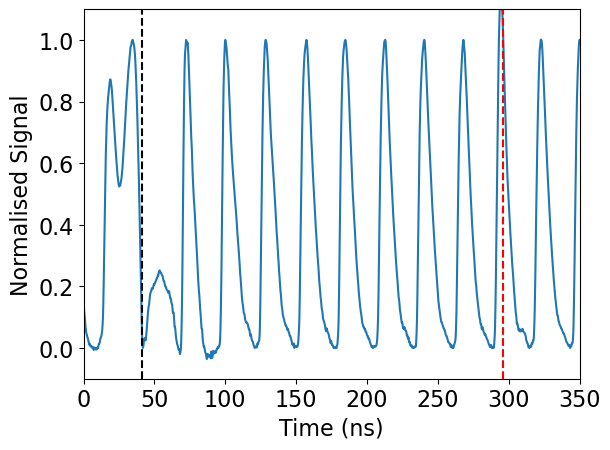

In [8]:
start = (xrayTime + dds[int(shotType)] + nominalTime - 400) * 1e-9
stop  = (xrayTime + dds[int(shotType)] + nominalTime + 150) * 1e-9
data_corrected = correct_envelope_splines(data_sub_bg, env_low, env_high)
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.plot(t_sub_bg*1e9, -data_corrected)
plt.xlim(np.array((start,stop))*1e9)
plt.ylabel('Normalised Signal')
plt.xlabel('Time (ns)')
plt.axvline(peak_time*1e9, color='red', linestyle='--', label='Background arrival time')
#plt.axvline(297+27.7, color='red', linestyle='--')
plt.xlim(0, 350)
plt.ylim(-0.1,1.1)
plt.axvline((sh_t - 2e-9)*1e9, color='black', linestyle='--')


In [9]:
bottoms = find_peaks(data_corrected, distance=200)[0]
t_bot = t_sub_bg[bottoms]
data_corrected = correct_envelope_splines(data_sub_bg, env_low, env_high)
bot_1, bot_1_index = find_nearest(t_bot, peak_time)
if t_bot[bot_1_index] <= peak_time:
    b1_i, b2_i = bottoms[bot_1_index], bottoms[bot_1_index+1]
    bot1 = bot_1_index
else:
    bl_i, b2_i = bottoms[bot_1_index-1], bottoms[bot_1_index]
    bot1 = bot_1_index-1

In [10]:
#perform refined centroid timing alignment
peak_time_c = peak_time
del_cs = []
pulses = 10
for i in range(11, 11 + pulses+1):
    i1 = bottoms[bot1 - i]
    i2 = bottoms[bot1 - i + 1]
    data_i = -data_corrected[i1:i2]
    t_i = t_sub_bg[i1:i2]
    toac_i = peak_time_c - (i)*period*1e-9
    peak_index = np.argmax(data_i)
    centroid = int_mean(data_i, t_i)
    del_cs.append(centroid-toac_i)
    
peak_time_c += np.mean(del_cs)
if peak_time_c-peak_time > 2e-8:
    peak_time_c -= period*1e-9
if peak_time_c - peak_time < -2e-8:
    peak_time_c += period*1e-9
time_err = np.std(del_cs) / np.sqrt(pulses)


In [11]:
m_Cr = 51.94 * m_u
def energy_t(t, d):
    E_J = 0.5 * m_Cr * (d / t)**2
    return E_J / (e * 1e6)

def time_E(E, d):
    E_J = E * e * 1e6
    return d * np.sqrt(m_Cr / (2 * E_J))

def energy_t_rel(t,d):
    E_J = m_Cr * c**2 * (np.sqrt(1 / (1 - (d/c/t)**2)) - 1)
    return E_J / (e * 1e6)

def time_E_rel(E, d):
    E_J = E * e * 1e6
    return d / (c * np.sqrt(1 - 1 / ((E_J / (m_Cr*c**2)+1)**2)))

def t2E_rel(t, I, t_0, E_0):
    dist = 12.13
    tt_0 = time_E_rel(E_0, dist)
    t_offset = tt_0 - t_0
    t_new = t + t_offset
    E = energy_t_rel(t_new, dist)
    E_J = E * e * 1e6
    jacobian = dist * (m_Cr * c**2)**2 / (c * (E_J + m_Cr * c**2)**3 * (1 - 1 / (E_J/m_Cr/c**2 + 1)**2)**(3/2))
    dn_dE = I * jacobian
    return dn_dE, E

In [12]:
bx = 0
b = 6
a = 0
def center_times(t_0, before, after, beforex):
    x_flash_i = int(np.ceil(t_0 / (period*1e-9))) 
    tbx = t_0 - (x_flash_i+1) * period*1e-9
    tbxb = tbx - beforex*period*1e-9
    t_b = t_0 - period*1e-9 * before
    t_a = t_0 + period*1e-9 * after
    tbxs = np.arange(tbxb, tbx+0.5*period*1e-9, period*1e-9)
    ts = np.arange(t_b, t_a + 0.5 * period*1e-9, period*1e-9)
    return ts, tbxs, t_b, t_a, tbx, tbxb
peak_times, peak_times_bx, t_b, t_a, t_bx, t_bxb = center_times(peak_time_c, b, a, bx)
t_bot_b = bisect(t_bot, t_b)-1

bot_cropped = bottoms[t_bot_b:]
bot_cropped_b = bot_cropped[:b+1]
bot_cropped_poi = bot_cropped[b:b+2]


In [13]:
#Time to energy conversion
E_bs = []
dn_dE_bs = []

for i in range(len(bot_cropped_b)-1):
    i_i = bot_cropped_b[i]
    i_f = bot_cropped_b[i+1]
    t_i = t_sub_bg[i_i:i_f]
    t_0 = peak_times[i]
    data_i = -data_corrected[i_i:i_f]
    dn_dE_i, E_i = t2E_rel(t_i, data_i, t_0, 52 * MeV_us[shotType])
    E_bs.append(E_i)
    dn_dE_bs.append(dn_dE_i)
    
i_i = bot_cropped_poi[0]
i_f = bot_cropped_poi[1]
t_i = t_sub_bg[i_i:i_f]
t_0 = peak_times[b]
data_i = -data_corrected[i_i:i_f]
dn_dE_poi, E_poi = t2E_rel(t_i, data_i, t_0, 52 * MeV_us[shotType])


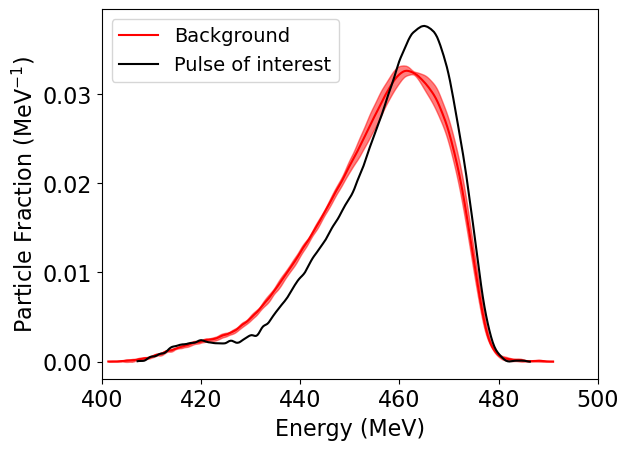

In [14]:
E_b, mean_b, std_b = mean_std_array(dn_dE_bs, E_bs, 5000)
norm = simpson(mean_b, x=E_b)
norm_poi = -simpson(dn_dE_poi, x=E_poi)
mean_b = mean_b / norm
std_b = std_b / norm
b_err0 = mean_b - std_b
b_err1 = mean_b + std_b

fig= plt.figure()
fig.tight_layout(pad=2)
plt.plot(E_b, mean_b, color='red', label='Background')
plt.fill_between(E_b, b_err0, b_err1, color='red', alpha=0.5)
plt.plot(E_poi, dn_dE_poi / norm_poi, color='black', label='Pulse of interest')
plt.xlabel('Energy (MeV)')
plt.ylabel(r'Particle Fraction ($\mathrm{MeV}^{-1}$)')
plt.xlim([400, 500])
plt.legend()

plt.legend(loc=2, prop={'size': 14})

GET RESULTS HERE


In [15]:
#calculating centroid shift in mean energy
norm_fact = [0.87, 1.09]
E_mean_b_high = int_mean(mean_b+std_b, E_b)
E_mean_b_low = int_mean(mean_b-std_b, E_b)
E_mean_b_c = int_mean(mean_b, E_b)
E_mean_poi = int_mean(dn_dE_poi, E_poi)
E_err_b_c = max(abs(E_mean_b_c-E_mean_b_high), abs(E_mean_b_c-E_mean_b_low))

print('Energy shift: ' + str(E_mean_poi - E_mean_b_c) + ' +/- ' + str(max([E_err_b_c,0.3]))+' MeV')
print('Normalised Energy shift: ' + str((E_mean_poi - E_mean_b_c)/norm_fact[shotType]) + ' +/- ' + str(max([E_err_b_c/norm_fact[shotType], 0.3/norm_fact[shotType]])))

Energy shift: 2.288521951715836 +/- 0.3 MeV
Normalised Energy shift: 2.6304850019722257 +/- 0.3448275862068965


In [16]:
width_background = 2*std_integral(E_b, mean_b, E_mean_b_c)
width_background_high = 2*std_integral(E_b, mean_b+std_b, E_mean_b_high)
width_background_low = 2*std_integral(E_b, mean_b-std_b, E_mean_b_low)
width_poi = 2*std_integral(E_poi, dn_dE_poi, E_mean_poi)
#print(width_background, width_background_2, width_poi, width_poi_2)
spread = width_poi-width_background
spread_err = max(abs(width_poi-width_background_high-spread), abs(width_poi-width_background_low-spread))
print('Energy broadening: ' + str(spread) + ' +/- ' + str(max([spread_err,0.6])) + ' MeV')
print('Normalised energy broadening: ' + str((spread)/norm_fact[shotType]) + ' +/- ' + str(max([spread_err/norm_fact[shotType], 0.6/norm_fact[shotType]])))

Energy broadening: -0.9690130713828786 +/- 0.6 MeV
Normalised energy broadening: -1.1138081280262973 +/- 0.689655172413793
